# Flash Method Data Reduction Using ODRPACK 
 (c) Jozef Gembarovic 2015, 2017

 ODRPACK (Orthogonal Distance Regression  PACKage) Version 2.1 - see [manual](https:#docs.scipy.org/doc/external/odrpack_guide.pdf)


### Three Layer Model for an Instantaneuos Pulse, with Zero Heat Losses
Consider a three layer specimen, with thermal diffusivities $\alpha_i$, specific heats $c_i$, and densities $\rho_i$ of the $i$-th layer, initially at constant (zero) temperature. Front surface of the first layer is uniformly irradiated with an instntaneous heat pulse at time $t=0$. Resulting heat flow s one dimensional and the specimen is thermally insulated from its ambient. 

Analytical formula for the temperature response at the rear face of a third layer in time $t > 0$ is 

$$ T(t, \alpha, L, c, \rho) = 1+2\sum_{n=1}^\infty \Psi_n e^{-\gamma_n^2t/\eta_3^2}, $$

where 
$$\Psi=\frac{\omega_1\chi_1+\omega_2\chi_2+\omega_3\chi_3}{\omega_1\chi_1\cos(\gamma_n\omega_1)+\omega_2\chi_2\cos(\gamma_n\omega_2)+\omega_3\chi_3\cos(\gamma_n\omega_3)+\omega_4\chi_4\cos(\gamma_n\omega_4)},$$

$$ \chi_1=H_{13}\eta_{31}+H_{12}\eta_{21}+H_{23}\eta_{32}+1,$$
$$ \chi_2=H_{13}\eta_{31}-H_{12}\eta_{21}+H_{23}\eta_{32}-1,$$
$$ \chi_3=H_{13}\eta_{31}-H_{12}\eta_{21}-H_{23}\eta_{32}+1,$$
$$ \chi_4=H_{13}\eta_{31}+H_{12}\eta_{21}-H_{23}\eta_{32}-1,$$

$$\omega_1=\eta_{13}+\eta_{23}+1,$$
$$\omega_2=\eta_{13}+\eta_{23}-1,$$
$$\omega_3=\eta_{13}-\eta_{23}+1,$$
$$\omega_4=\eta_{13}-\eta_{23}-1,$$


and $\gamma$ are positive roots of 

$$ \chi_1\cos(\gamma\omega_1)+\chi_2\cos(\gamma\omega_2)+\chi_3\cos(\gamma\omega_3)+\chi_4\cos(\gamma\omega_4)=0.$$

Volumetric heat capacity $H_i$ and square root heat diffusion time $\eta_i$ of the $i$-th layer, are defined as

$$ H_i=a\rho_ic_iL_i, \quad \eta_i=L_i/\sqrt{\alpha_i}, \quad i=1,2,3,$$

where $a$ is the cross sectional area of the specimen.

Relative volumetric heat capacity $H_{ij}$ and relative square root heat diffusion time $\eta_{ij}$, are defined as

$$ H_{ij}=H_i/H_j, \quad \eta_{ij}=\eta_i/\eta_j, \quad i,j=1,2,3.$$


In [60]:
%pylab inline

import numpy as np # for Numerical Python
import scipy.special as scs # for Bessel functions 
from scipy.optimize import brenth # for finding zeroes of a function
import scipy.odr.odrpack as odrpack #  for ODRPACK
import os # for files manipulatios (operating system package)
from matplotlib import pyplot # for plots
from matplotlib import gridspec # for resizing figures

Populating the interactive namespace from numpy and matplotlib


###  Three Layer Model Functions

In [61]:
# 3LAYER FLASH MODEL WITHOUT HEAT LOSSES AND 
#   WITHOUT THERMAL CONTACT RESISTANCE,  
#   for an instantaneous heta pulse 

# (c) Jozef Gembarovic 2/9/2015, 1/23/2017

#  Definition of the function f3L(x) used in brenth
def  f3L (x, X, omega):
    value = X[1]*sin(omega[1]*x)+X[2]*sin(omega[2]*x) \
           +X[3]*sin(omega[3]*x)+X[4]*sin(omega[4]*x) 
    return (value) 

def rootsearch3L(f,a,b,X,omega,dx):
    x1 = a;  f1 = f(a, X, omega)
    x2 = a + dx;  f2 = f(x2, X, omega)
    while f1*f2 > 0.0:
        if x1 >= b:
            return None,None
        x1 = x2;  f1 = f2
        x2 = x1 + dx;  f2 = f(x2, X, omega)
    return x1,x2

def mroots3L(f, X, omega, a, b, eps=1e-2):

    i=0
    myroots=[]
    while 1:
        x1,x2 = rootsearch3L(f,a,b,X,omega,eps)
        if x1 != None:
            a = x2
            root = brenth(f,x1,x2, args =(X,omega), xtol=1e-16)
            if root != None:
                pass
            myroots.append(root)
            i = i+1
        else:
            return myroots        
            break


# function vecd is used in V3
def  vecd (gama, X, omega):
    oX  = omega*X
    values = []  
    for i in range(len(gama)):
        value=oX[1]*cos(omega[1]*gama[i])+oX[2]*cos(omega[2]*gama[i])\
             +oX[3]*cos(omega[3]*gama[i])+oX[4]*cos(omega[4]*gama[i])
        values.append(value)
 
    return (values) 


#calculate temperature value at rear side of a three layer sample
def V3 ( time, thickness, cp, alpha, rho):
    # define vectors and matrices
    h = [0, 0, 0, 0]
    n = [0, 0, 0, 0]
    
    X = [0, 0, 0, 0, 0]
    omega = [0, 0, 0, 0, 0]
    
    H = [[0 for i in range(4)] for j in range(4)]
    N = [[0 for i in range(4)] for j in range(4)]

    # calculate auxiliary variables
    #    h=rho*cp*thickness
    for i in range(1,4): 
        h[i] = rho[i-1]*cp[i-1]*thickness[i-1]
        n[i] = thickness[i-1]/sqrt(alpha[i-1])
    
    for i in range(1,4): 
        for j in range(1,4): 
            H[i][j] = h[i]/h[j]
            N[i][j] = n[i]/n[j]
    
    X[1]= H[1][3]*N[3][1] + H[1][2]*N[2][1] + H[2][3]*N[3][2] + 1.0 
    X[2]= H[1][3]*N[3][1] - H[1][2]*N[2][1] + H[2][3]*N[3][2] - 1.0     
    X[3]= H[1][3]*N[3][1] - H[1][2]*N[2][1] - H[2][3]*N[3][2] + 1.0 
    X[4]= H[1][3]*N[3][1] + H[1][2]*N[2][1] - H[2][3]*N[3][2] - 1.0 
    X = np.array(X)
    
    omega[1] = N[1][3] + N[2][3] + 1.0  
    omega[2] = N[1][3] + N[2][3] - 1.0 
    omega[3] = N[1][3] - N[2][3] + 1.0 
    omega[4] = N[1][3] - N[2][3] - 1.0 
    omega = np.array(omega)    
    
    cons = np.dot(omega,X)
    ns    = n[3]*n[3]
    
    gama = mroots3L(f3L, X, omega, a=0.00001, b=100.0, eps=1.0e-2) 
    gama = np.array(gama)
  
    vd = vecd(gama, X, omega)  
    vd = np.array(vd)
    vdcons = vd/cons/2
    
    gamasq = gama*gama 
    timens=time/ns
    
    Suma=[]
    for j in range(len(time)):
        suma = 1.0
        for i in range(len(gama)):
            if time[j]<=0.0001 :
                    suma=0.0 
            else:
                suma += exp(-gamasq[i]*timens[j])/vdcons[i]      
        Suma.append(suma)
        
    return (Suma)

### Simulate 'experimental' data
using three layer model functions 

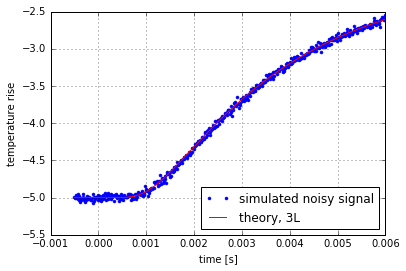

In [62]:
N=500 # number of experimental point
time = np.linspace(-0.0005,0.006,N) # define time points in seconds
noise = 0.03 # sigma (relative to Tmax) for noise level
# Theoretical values
# my theoretical values used for calculation 
# of 'experimental' data, feel free to change them!
baseline_theor = -5.0
Tmax_theor = 3.0  # Tmax 
td_theor = 1.17 # thermal diffusivity in cm^2/s (Copper at RT)

# new vector of theoretical parameters 
theors = [baseline_theor, Tmax_theor, td_theor] 


# parameters for the three layer specimen
alpha3L=[td_theor ,td_theor/4 ,td_theor]
cp3L = [0.4, 0.4, 0.5] # specific heat
rho3L = [8.0, 7.0, 5.0] # density
thickness3L = [0.05, 0.04, 0.02] # diffusivity

# thoery
temperature3L = (baseline_theor 
+Tmax_theor*np.array(V3(time,thickness3L, cp3L, alpha3L, rho3L)))

# add some noise to immitate a real signal
temperature3Ln = temperature3L + np.random.normal(0,noise,N)

# plot simulated data
pyplot.plot(time, temperature3Ln,'b.', label='simulated noisy signal') 
pyplot.plot(time, temperature3L,'r', label='theory, 3L') 

pyplot.xlabel("time [s]")
pyplot.ylabel("temperature rise")
pyplot.legend(loc=4)
pyplot.grid()
pyplot.show()


### Here goes ODRPACK

In [63]:
# first delete the file 'filename' if it already exist to
# make room for a new one, generated by the ODRPACK
filename="res3LODR.txt" 
## delete only if file exists ##
if os.path.exists(filename):
    os.remove(filename)
else:
    print ("Sorry, I can not remove %s file." % filename)
    
# define analytical function for temperature distribution used by the fitting procedure
def flash3L(B, t):
    alpha3L = [td_theor, td_theor/4, B[2]]
    return (B[0]+B[1]*np.array(V3(time,thickness3L, cp3L, alpha3L, rho3L))) 
    
flash = odrpack.Model(flash3L) 

mydata = odrpack.RealData(time, temperature3Ln, sx=0.00001, sy=0.0001) 

myodr = odrpack.ODR(mydata, flash, beta0=[-5.2, 3.5, 1.0], job=3, 
                    iprint =6616, ifixb=[1,1,1], rptfile=filename)             
# for the baseline level, Beta[0], Tmax, Beta[1], 
# the thermal diffusivity of the third layer, Beta[2]
                                                    
myoutput = myodr.run() # run Forrest (ODRPACK), run!!
myoutput.pprint () # pr  a standard simple output

# a more detail report from the ODRPACK is in a freshly created text file
# the analysis time ~ 5 s, on work PC

Beta: [-4.99726659  3.00880926  1.02166535]
Beta Std Error: [ 0.00272771  0.00521061  0.04746004]
Beta Covariance: [[  8.59474434e-11  -4.03956052e-11  -9.28864547e-10]
 [ -4.03956052e-11   3.13626778e-10  -1.36416613e-09]
 [ -9.28864547e-10  -1.36416613e-09   2.60190662e-08]]
Residual Variance: 86569.40469653426
Inverse Condition #: 0.029288480704124837
Reason(s) for Halting:
  Sum of squares convergence


### Reconstruct the theoretical temperature rise from calculated parameters 

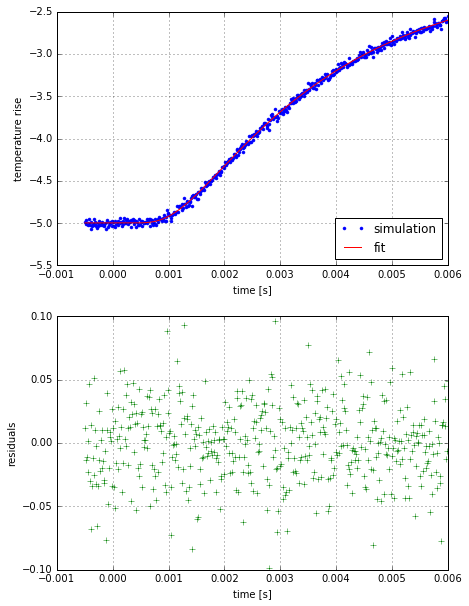

Relative differences [baseline level, Tmax, thermal diffusivity, Biot number] in percent are: 
 [ -0.05466811   0.29364184 -12.6781755 ]

 
 Histogram of residuals


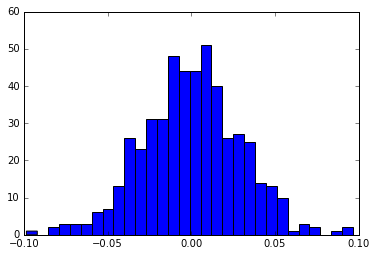

In [64]:
B = myoutput.beta # final results of calculated optimal parameters

theory = B[0]+B[1]*np.array(V3(time,thickness3L, cp3L, [td_theor,td_theor/4,B[2]], rho3L))


fig = pyplot.figure(figsize=(7, 10)) 

pyplot.figure(1)
pyplot.subplot(211)
pyplot.plot(time, temperature3Ln, 'b.', label="simulation")
pyplot.plot(time, theory,'r', label="fit")
pyplot.xlabel("time [s]")
pyplot.ylabel("temperature rise")
pyplot.legend(loc=4)
pyplot.grid()

residuals = temperature3Ln - theory

pyplot.subplot(212)
pyplot.plot(time, residuals, 'g+', label="residuals")
pyplot.xlabel("time [s]")
pyplot.ylabel("residuals")
pyplot.grid()

pyplot.show()

pyplot.hist(residuals, 30) # plot histogram of residuals

# calculate relative differences between 
# the thoretical and calculated parameters
theors =[-5,3,td_theor]
diffs = (B-theors)/theors*100 
diffs
print  ("Relative differences [baseline level, Tmax,"
       +" thermal diffusivity, Biot number] in percent are: \n",
       diffs)
print  ("\n \n Histogram of residuals")


## The End

In [65]:
H=[[0 for i in range(5)] for j in range(5)]

In [66]:
H

[[0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0]]